In [1]:
%run -m ipy_startup
%matplotlib inline
%load_ext rpy2.ipython
from genomics import data as gnd

In [2]:
import imp
imp.reload(gnd)

<module 'genomics.data' from '/Users/eczech/repos/portfolio/functional/ml/python/genomics/data.py'>

# Data Loading

In [3]:
datasets = gnd.get_raw_datasets()

Removing 6127 cols with more than 10 pct NA values
Removing 808 cols with more than 10 pct NA values


In [4]:
data = gnd.join_all_datasets(datasets, na_thresh=.9)

Frequency of row-wise NA pct values over threshold for removal:
1    5
dtype: int64
Frequency of row-wise NA pct values over threshold for removal:
1    5
dtype: int64
The following tumors will be removed due to high sparsity in their feature values: ['COLO699', 'HCC1359', 'HCC1833', 'HCC2108', 'NCIH2073', 'T3M10']


In [5]:
data['response'] = gnd.get_response_value(data)

In [6]:
data.head()

,tumorID,res_AUC,res_IC50,type,ge:A1BG,ge:A1CF,ge:A2M,ge:A2M.AS1,ge:A2ML1,ge:A4GALT,...,cn:YRDC,cn:YTHDC1,cn:YTHDC2,cn:YTHDF1,cn:YTHDF2,cn:YTHDF3,cn:YWHAB,cn:YWHAE,cn:YWHAG,response
0,AMO1,7.1835,NaN,o,0.4770,-0.3916,-0.4094,-0.0089,-0.4782,-0.8503,...,-0.18340,-0.25810,-0.7720,0.2163,-0.21330,0.1291,0.2213,0.2267,0.13660,1.666203
1,BL70,5.1900,NaN,o,0.3490,-0.2798,-0.4107,-0.5269,-0.2551,0.3981,...,-0.01730,-0.04686,-0.0203,-0.0004,-0.01730,-0.0121,-0.0004,-0.0448,0.45760,0.535292
2,C2BBE1,5.1650,NaN,o,-1.1575,2.1572,-0.4039,-0.2162,-0.0852,-0.2069,...,-0.87820,-0.13750,0.1065,1.0180,-0.90450,-0.1152,1.0180,0.3355,0.04546,0.521109
3,CALU3,3.0088,NaN,o,-1.4094,-0.0233,-0.3574,0.1450,-0.2354,0.4110,...,-0.01131,-0.32610,0.4294,0.7361,-0.01131,-0.3379,0.6641,-0.5947,-0.36980,-0.702101
4,CALU6,3.0762,NaN,o,-1.0876,-0.2483,-0.5084,-0.7926,-0.0924,0.8559,...,-0.39530,-0.38950,-0.3840,0.7720,-0.39670,0.3494,0.3225,0.5363,0.25240,-0.663865


# Data Prep

For several different hold out set sizes:
1. Split data into training and hold out
2. Fit normalizing transforms on training data and apply to hold out
3. Match features in hold out to training
4. Store both training and hold out sets

In [33]:
def split_data(data, n_ho=30, n_features=8000, n_min_mu=3):
    # Split into training and holdout
    is_ho = gnd.get_hold_out_mask(data, n_ho=n_ho)
    d_ho, d_tr = data.loc[is_ho], data[~is_ho]
    
    # Scale and dummy encode
    d_tr, scalers = gnd.prep_data(d_tr, scalers=None)
    d_ho, _ = gnd.prep_data(d_ho, scalers=scalers)
    
    # Run feature selection
    d_tr, d_ho = gnd.normalize_data_split(d_tr, d_ho, min_mu_ct=n_min_mu)
    d_tr, d_ho = gnd.select_features(d_tr, d_ho, k=n_features)
    
    return d_tr, d_ho

In [37]:
#for n_ho in [30, 45, 60, 75, 90, 105]:
for n_ho in [275, 300]:
    print('Creating data sets with hold out size {}'.format(n_ho))
    d_tr, d_ho = split_data(data, n_ho=n_ho, n_features=8000)
    gnd.export_dataset(d_tr, d_ho, n_ho)

Creating data sets with hold out size 275
Creating data sets with hold out size 300


In [ ]:
#d_tr_prep.reset_index().plot(kind='scatter', y='response', x='cn:A2M')

# Modeling

In [7]:
n_ho = 30
d_tr, d_ho = gnd.load_dataset(n_ho)

In [14]:
# Imports
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import KFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, RandomizedLasso, Ridge, ElasticNetCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_ridge import KernelRidge
from ml.model import models, common, importances
from ml.model import summaries as ml_precis
from ml.model import ensemble

In [9]:
# Grid Specifications

# gbr_grid = {
#     'n_estimators': [1, 100, 1000],
#     'learning_rate': [.001, .01, .1, 1],
#     'min_samples_leaf': [1, 2, 5],
#     'max_depth': [1, 5, 13]
# }
gbr_grid = {
    'n_estimators': [100],
    'learning_rate': [.01, .1, .2],
    'min_samples_leaf': [3, 17, 25],
    'max_depth': [5],
    'max_features': [.3, .5, .7]
}
rf_grid = {
    'n_estimators': [1, 10, 100, 250],
    'min_samples_leaf': [1, 3],
    'max_depth': [1]
}
etr_grid = {
    'n_estimators': [10],
    'min_samples_leaf': [5],
    'min_samples_split': [10],
    'max_features': ['auto', .1, .3, .5, .8],
    'max_leaf_nodes': [40, 60, 80],
    'max_depth': [None]
}
svr_grid = {
    'C': np.logspace(-1, 2, 6),
    'degree': [3],
    'gamma': np.logspace(-6, -3, 6),
    'kernel': ['rbf'],
    'max_iter': [15000]
}
ridge_grid = {
    'alpha': np.logspace(-2, 5, 50)
}
enet_grid = {
    'l1_ratio': [.1, .3, .5, .7, .9, 1]
}
nys_grid = {
    'feat__n_components': [100, 232],
    'feat__gamma': [.00006, .00001, .0001],#np.logspace(-6, -3, 8),
    'est__alpha': np.logspace(-3, 1, 5)
}


In [10]:
# Learner Specifications

etr = ExtraTreesRegressor(n_estimators=100, max_depth=None, max_leaf_nodes=100, 
                          min_samples_leaf=5, min_samples_split=10, max_features=.85, n_jobs=-1)

#rf = RandomForestRegressor()
gbr = Pipeline([ 
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=.8)), 
            ('est', GridSearchCV(GradientBoostingRegressor(), gbr_grid, n_jobs=-1))
        ])

ridge = Pipeline([ 
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=.5)),
            ('est', GridSearchCV(Ridge(normalize=True), ridge_grid, n_jobs=-1))
        ])
lasso = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=.5)), 
            ('est', LassoCV(normalize=True, n_jobs=-1))
        ])
enet = Pipeline([ 
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=.5)), 
            ('est', GridSearchCV(ElasticNetCV(n_jobs=-1, cv=5, max_iter=10000, normalize=True), enet_grid))
        ])

nys =  GridSearchCV(Pipeline([ 
        ('scale', StandardScaler()),
        #('pca', PCA(n_components=.9)),
        ('feat', Nystroem()),
        ('est', Ridge()) 
    ]), nys_grid, cv=5, n_jobs=1)

svr = GridSearchCV(SVR(), svr_grid, cv=5, n_jobs=1)

In [11]:
features = [c for c in d_tr if c != 'response']
X, y = d_tr[features], d_tr['response']

n_jobs = -1

ens = ensemble.EnsembleRegressor([enet, ridge, etr, svr])
#clfs = {'ridge': ridge, 'lasso': lasso, 'ens': ensemble}
#clfs = {'enet': enet}
clfs = {'nys': nys}

res = models.run_regressors(
    X, y, clfs, KFold(len(y), 10), keep_X=False, 
    par_n_jobs=1, par_verbose=1,
    log_file='/tmp/genomics_cv.log')

INFO:ml.model.log:Running model nys (Pipeline) on fold 1


Beginning cross validation (see /tmp/genomics_cv.log for progress updates)


KeyboardInterrupt: 

In [ ]:
#PCA(n_components=.75).fit_transform(X).shape

In [ ]:
ml_precis.summarize_grid_parameters(res)

In [ ]:
from sklearn.metrics import mean_squared_error
score_func = lambda clf, y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
#score_func = lambda clf, y_true, y_pred: mean_squared_error(y_true, y_pred)
scores = models.summarize_scores(res, score_func)
scores.groupby('model_name').mean()

In [ ]:
ml_precis.plot_model_scores(res, score_func)

In [ ]:
ml_precis.plot_feature_importance(res)

In [ ]:
preds = models.summarize_predictions(res)

# Predictions

In [15]:
nys_grid = {
    'feat__n_components': [100],
    'feat__gamma': [.00006],
    'est__alpha': np.logspace(-3, 1, 5)
}
nys =  GridSearchCV(Pipeline([ 
        ('scale', StandardScaler()),
        ('feat', Nystroem()),
        ('est', Ridge()) 
    ]), nys_grid, cv=5, n_jobs=1)

In [16]:
def get_results(n_ho):
    ens = ensemble.EnsembleRegressor([enet, ridge, nys])
    d_tr_p, d_ho_p = gnd.load_dataset(n_ho)
    features = [c for c in d_tr_p if c != 'response']
    X, y = d_tr_p[features], d_tr_p['response']
    ens.fit(X, y)
    X_ho = d_ho_p[features]
    y_ho = ens.predict(X_ho)
    return y_ho, d_ho_p['response']

In [21]:
n_hos = list(np.arange(30, 196, 15)) + [225, 250]
n_hos

[30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 225, 250]

In [38]:
n_hos = list(np.arange(30, 196, 15)) + [225, 250, 275, 300]
#n_hos = [180]
res = []
for n_ho in n_hos:
    y_pred, y_true = get_results(n_ho)
    res.append(pd.DataFrame({'n_ho': np.repeat(n_ho, len(y_pred)), 'y_pred': y_pred, 'y_true': y_true}))
import functools
res = functools.reduce(pd.DataFrame.append, res)
res.head()

,,,,n_ho,y_pred,y_true
tumorID,res_AUC,res_IC50,type,,,
CAOV3,4.6915,NaN,o,30,0.272030,0.252493
CL40,4.0669,NaN,o,30,0.037101,-0.101842
CORL51,1.3704,NaN,o,30,-1.089003,-1.631564
HEC251,4.2839,NaN,o,30,-0.004825,0.021262
HEC6,4.0177,NaN,o,30,0.307861,-0.129753


/Users/eczech/anaconda/envs/research3.4/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: Saving 11.1 x 11.1 in image

  res = super(Function, self).__call__(*new_args, **new_kwargs)


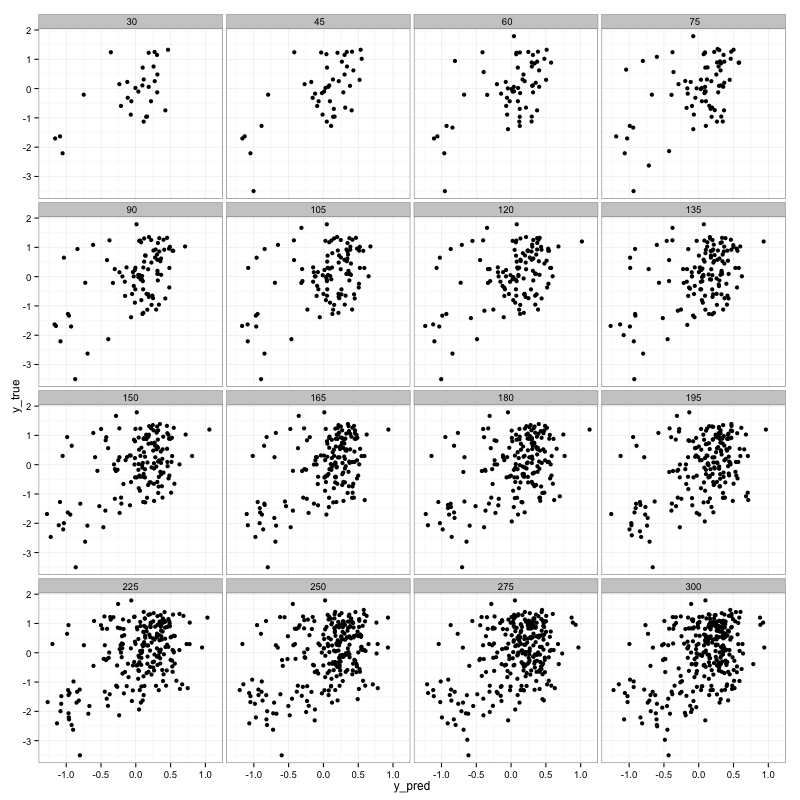

In [42]:
%%R -i res -w 800 -h 800 -u px
library(dplyr)
library(ggplot2)
res %>% mutate_each(funs(as.numeric)) %>%
    ggplot(aes(x=y_pred, y=y_true)) + geom_point() + facet_wrap(~n_ho) +
    theme_bw() + 
    ggsave('/Users/eczech/repos/misc/Charleston-Data-Analytics-Cancer-Genomics-Data-Challenge/modeling/images/ho_predictions.png')

In [27]:
# plt.scatter(y_ho, d_ho_p['response'])
# plt.gca().set_xlim(-2, 1)

# Clustering

In [40]:
n_ho = 30
d_tr, d_ho = split_data(data, n_ho=n_ho, n_features=100)

In [41]:
d_tr.reset_index().to_csv('/Users/eczech/data/meetups/genomics/feature_correlation_n100.csv', index=False)

In [48]:
p = d_tr.reset_index()
#d_tr.plot(kind='scatter', x='cn:SLC26A2', y='ge:SOX4')
p['color'] = p['type'].map({'o': 0, 'c': 2, 'h': 1}).astype(np.int64)
p = p[['cn:PDE6A','cn:SLC26A2','color']]

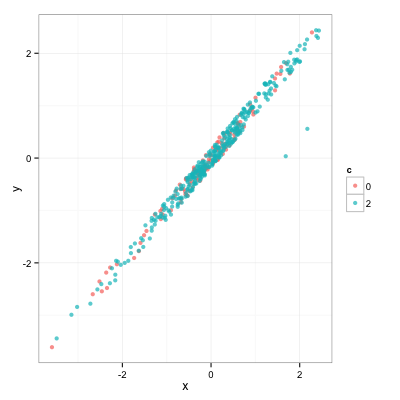

In [49]:
%%R -i p -w 400 -h 400 -u px
library(dplyr)
library(ggplot2)
library(reshape2)
p %>% mutate_each(funs(as.numeric)) %>% mutate(color=factor(color)) %>% setNames(c('x', 'y', 'c')) %>% 
    ggplot(aes(x=x, y=y, color=c)) + geom_jitter(alpha=.7, position = position_jitter(width = .2)) + 
    theme_bw()

In [10]:
cors = d_tr.corr()

In [11]:
from sklearn.manifold import TSNE, MDS
#tsne = TSNE().fit_transform(d_tr.T)
mds = MDS().fit_transform(cors)

/Users/eczech/anaconda/envs/research3.4/lib/python3.4/site-packages/sklearn/manifold/mds.py:394: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity=precomputed``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [12]:
mds.shape

(1000, 2)

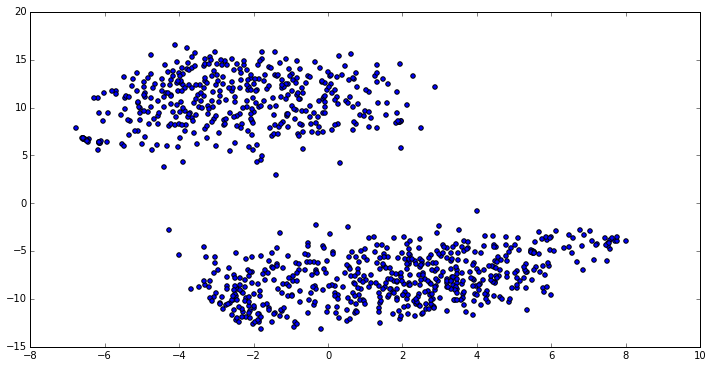

In [13]:
plt.scatter(mds[:, 0], mds[:, 1])
plt.gcf().set_size_inches(12, 6)